In [1]:
import pickle
import imageio
import geopandas as gpd

In [2]:
#define SOM class and functions
%run main_class.ipynb

# Example: Seasonal streamflow in south-western Canada

In [3]:
#define a function to plot provincial borders

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = './Data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

In [4]:
#load data
dir_data = './Data/' #folder where data is saved

#load seasonal flow
pickle_in = open(dir_data + 'flowseason_norm.pickle','rb')
flowseason_norm = pickle.load(pickle_in).T

#load station_data
df = pd.read_csv(dir_data + 'station_info.csv')
stationLon = df['Longitude'].values
stationLat = df['Latitude'].values
Nstations = len(stationLat)

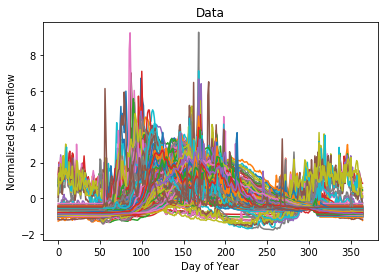

In [5]:
#visualize seasonal streamflow data in time

obs = flowseason_norm

fig, ax = plt.subplots()
for ob in obs:
    ax.plot(ob)
ax.set_xlabel('Day of Year')
ax.set_ylabel('Normalized Streamflow')
ax.set_title('Data')

plt.show()

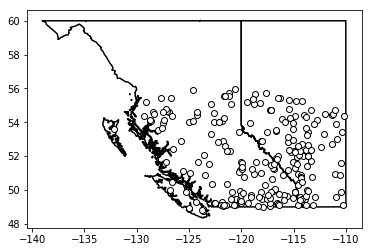

In [6]:
#visualize station locations

fig, ax = plt.subplots()
plot_prov_ax(['BC','AB'], ax)
ax.scatter(stationLon,stationLat, zorder = 5, facecolor = 'w', edgecolor = 'k')

In [7]:
#make and train the self-organizing map

#define constants
Nx = 4
Ny = 3
N_nodes = Nx*Ny
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 200
colours_list = 'pink_blue_red_purple'
colours_list = 'pinks'
colours_list = 'default2'

#initialize
som = SOM(Nx, Ny, obs, N_epochs, colours_list = colours_list)
som.initialize_map(node_shape = 'hex')

#train
som.train_map(learning_rate)
z = som.z
z_epochs = som.z_epochs
bmus = BMUs(som)
freq = BMU_frequency(som)
dummy,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny)
QE = som.QE()
TE = som.TE()

In [8]:
QE, TE

(64.24961573216967, 0.013274336283185861)

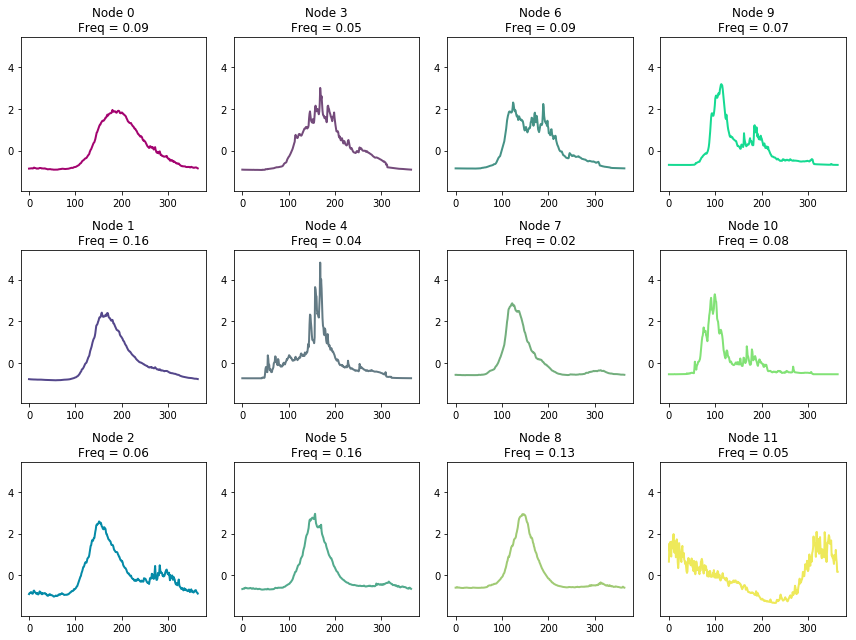

In [9]:
#visualize the SOM in map-space
fig, axes = som.plot()

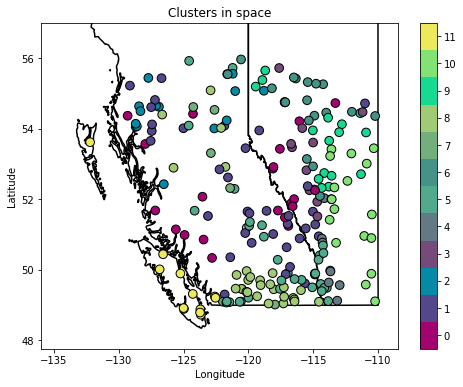

In [10]:
#visualize clusters in data-space

from matplotlib import cm
from matplotlib.colors import BoundaryNorm, ListedColormap

fig, ax = plt.subplots(figsize = (8,6))

#colours
cmap = ListedColormap(bmus_colours)
bounds = np.arange(N_nodes+1)-0.5
norm = BoundaryNorm(bounds, cmap.N)

plot_prov_ax(['AB', 'BC'], ax)
sp = ax.scatter(stationLon, stationLat, s = 75, zorder = 5, c = bmus, edgecolor = 'k', cmap = cmap, norm = norm) #observations, coloured by BMU
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_ylim(top = 57)
ax.set_xlim(left = -136)
cb = plt.colorbar(sp)
cb.set_ticks(np.arange(N_nodes))
ax.set_title('Clusters in space')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

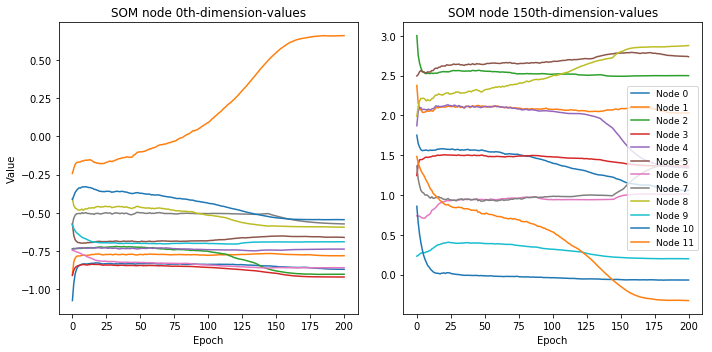

In [11]:
#visualize how som nodes in data-space change through training -- when these stabalize, it is a sign that the map has converged

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

for node in range(N_nodes):
    ax[0].plot(som.z_epochs[node,0,:].T)
    ax[1].plot(som.z_epochs[node,150,:].T, label = 'Node ' + str(node))

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].set_title('SOM node 0th-dimension-values')
ax[1].set_title('SOM node 150th-dimension-values')
ax[1].legend(fontsize = 9)

plt.tight_layout()
plt.show()

### Make GIF of training

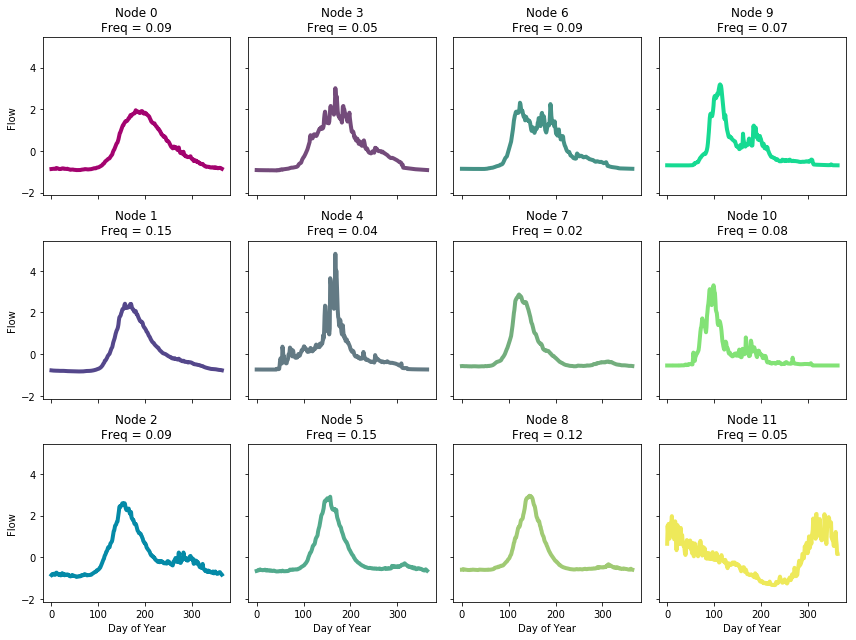

In [185]:
border = 0.1*(np.max(z_epochs) - np.min(z_epochs))
indices = np.arange(N_nodes).reshape(Nx,Ny).T.flatten()
bmus = BMUs(som)
dummy,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny)

fig, axes = plt.subplots(nrows = Ny, ncols = Nx, figsize = (3*Nx, 3*Ny))

epoch = N_epochs
for kk, ax in enumerate(axes.flatten()): #for each axis (subplot)
    var = z_epochs[indices[kk],:,epoch]
    ax.plot(var, color = bmus_colours[indices[kk],:], linewidth = 4)
    ax.set_ylim(bottom = np.min(z_epochs)-border, top = np.max(z_epochs)+border)
    ax.set_title('Node ' + str(indices[kk]) + '\nFreq = ' + str(np.round(BMU_frequency(som)[indices[kk]], decimals = 2)))
    
    #label only leftmost axes
    if np.mod(kk,Nx)==0:
        ax.set_ylabel('Flow')
    else:
        ax.tick_params(labelleft = False)
    if kk>=N_nodes-Nx:
        ax.set_xlabel('Day of Year')
    else:
        ax.tick_params(labelbottom = False)
    
plt.tight_layout()

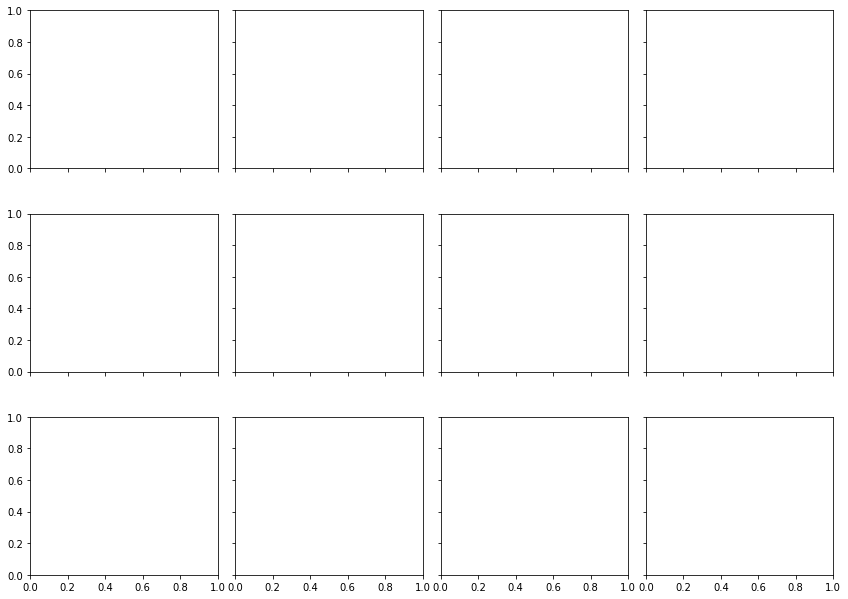

In [189]:
#help from: https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30

#save figure of each epoch of SOM as png, then stitch pngs together as a gif

border = 0.1*(np.max(z_epochs) - np.min(z_epochs))
indices = np.arange(N_nodes).reshape(Nx,Ny).T.flatten()
bmus = BMUs(som)
dummy,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny)

fig, axes = plt.subplots(nrows = Ny, ncols = Nx, figsize = (3*Nx, 3*Ny))

filenames = []

for epoch in range(N_epochs):

    for kk, ax in enumerate(axes.flatten()): #for each axis (subplot)
        
        var = z_epochs[indices[kk],:,epoch]
        ax.plot(var, color = bmus_colours[indices[kk],:], linewidth = 4)
        ax.set_ylim(bottom = np.min(z_epochs)-border, top = np.max(z_epochs)+border)
        ax.set_title('Node ' + str(indices[kk]) + '\nFreq = ' + str(np.round(BMU_frequency(som)[indices[kk]], decimals = 2)))

        #label only leftmost and bottom axes
        if np.mod(kk,Nx)==0:
            ax.set_ylabel('Flow')
        else:
            ax.tick_params(labelleft = False)
        if kk>=N_nodes-Nx:
            ax.set_xlabel('Day of Year')
        else:
            ax.tick_params(labelbottom = False)
            
    plt.tight_layout()
        
    filename = 'epoch_' + str(epoch) + '.png'
    filenames.append(filename)

    plt.savefig('./gif_flow/'+filename, bbox_inches = 'tight')

    for ax in axes.flatten():
        ax.clear()


In [199]:
#save as a gif
with imageio.get_writer('./gif_flow/som_flow.gif', mode = 'I') as writer:
  for kk, filename in enumerate(filenames):
    if np.mod(kk,5)==0:
      image = imageio.imread('./gif_flow/'+filename)
      writer.append_data(image)

# # If you want to remove files
# for filename in set(filenames):
#   os.remove(filename)